# Speech Dereverberation using U-Net Architectures
*Zachary Neveu*

## Imports and Hyperparams

In [1]:
from imports import *
import AudioTransforms
from DeReverbDataset import *
from utils import *
%matplotlib inline
from fastprogress import master_bar, progress_bar

In [82]:
from pesq import pesq
from pystoi.stoi import stoi
from pydsm import iso226
import pandas as pd

In [3]:
plt.style.use('ggplot')  # Just changes plotting theme, comment out if annoying
matplotlib.rcParams['figure.figsize'] = [10, 8]

Hyperparams for Data

In [4]:
speech_sr = 16000
frame_len = 16384
bs = 64
sr = 16000
data_path = Path("/home/zach/Data/dereverb")

## Create Transforms
`rev_tfms` is the transforms that will only be applied to the reverberant audio (input)  
`clean_tfms` is the transforms that will also be applied to the clean audio signal (target)

Note: if sample rate of files does not match sample rate passed, transforms will resample all audio files they need. This can take a *WHILE* if the conflicting sample rates are not integer multiples.

In [5]:
irfs = (data_path/'impulse-responses').ls()[0]
noisefs = (data_path/'noise').ls()[0]
rev_tfms = transforms.Compose([AudioTransforms.Noise(data_path/'noise', None, -12, 2),#])
                               AudioTransforms.Reverb(data_path/'impulse-responses', speech_sr),
                               AudioTransforms.Normalize()])

clean_tfms = transforms.Compose([AudioTransforms.Normalize()])
crop_load = AudioTransforms.LoadCrop(length=frame_len, no_rand=False)

## Create a Dataset

In [6]:
dataset = DeReverbDataset(data_path, rev_tfms=rev_tfms, clean_tfms=clean_tfms, crop_load=crop_load)

train_size = int(0.8 * len(dataset))
valid_size = len(dataset) - train_size
train_ds, valid_ds = torch.utils.data.random_split(dataset, [train_size, valid_size])

## Create a Dataloader

In [7]:
train_dl = DataLoader(train_ds, batch_size=bs, shuffle=True, num_workers=6, pin_memory=False)
valid_dl = DataLoader(valid_ds, batch_size=bs, shuffle=True, num_workers=6, pin_memory=False)

## Check out some data

## Frequency Domain Network

Figure from Pandey-Wang paper

![unet](papers/images/unet-inspired.png)

In [8]:
def encoder_block(sizes, i, kernel_size, padding):
    return nn.Sequential(
        nn.Conv1d(sizes[i-1][1], sizes[i][1], kernel_size, 2, padding, dilation=1),
        nn.BatchNorm1d(sizes[i][1]),
        nn.ReLU(),
    )

def decoder_block(sizes, i, kernel_size, padding):
    return nn.Sequential(
        nn.ConvTranspose1d(2*sizes[-i+1][1], sizes[-i][1], kernel_size, 2, padding, 1, dilation=1),
        nn.BatchNorm1d(sizes[-i][1]),
        nn.ReLU()
    )

In [9]:
class FDConvNet(nn.Module):
    def __init__(self, kernel_size):
        super(FDConvNet, self).__init__()
        sizes = [(2048, 64), (1024, 64), (512, 64), (256, 128), (128, 128), (64, 128), (32, 256), (16,256), (8, 256)]
        self.sizes = sizes
        padding = kernel_size // 2
        self.input = nn.Conv1d(1, sizes[0][1], kernel_size, 1, padding)
        
        self.encoder = nn.Sequential(
            *[encoder_block(sizes, i, kernel_size, padding) for i in range(1, len(sizes))]
        )
        self.decoder = nn.Sequential(
            *[decoder_block(sizes, i, kernel_size, padding) for i in range(2,len(sizes)+1)]
        )
        
        self.output = nn.ConvTranspose1d(sizes[0][1], 1, kernel_size, 1, padding)
        
    def forward(self, x):
        x = self.input(x)
        enc_outs = []
        for l in self.encoder:
            x = l(x)
            enc_outs.append(x)
        for i,l in enumerate(self.decoder):
            x = l(torch.cat((x, enc_outs[-i-1]), 1))
        x = self.output(x)
        return F.relu(x)
    
    def reconstruct(self, x, hop_len=256):
        x = x.detach().cpu()
        size = 2*self.sizes[0][0]
        window = torch.from_numpy(cola_window(size, hop_len)).float()
        output = torch.zeros(x.shape)
        for frame in range(x.shape[-1]//hop_len):
            try:
                f = x[:,hop_len*frame:hop_len*frame+size]
                amp,phase = fourier(f.squeeze())
                amp = amp[:size//2]
                phase = phase[:size//2]
                amp = self.forward(amp.unsqueeze(0).unsqueeze(0).cuda()).detach().cpu()
                f = torch.cat((amp.squeeze().unsqueeze(-1),phase.unsqueeze(-1)), dim=-1)
                f = polar_to_cart(f)
                f = f.irfft(1)
                windowed = window[:f.shape[0]] * f
                output[:,hop_len*frame:hop_len*frame+windowed.shape[0]] += windowed
            except Exception as E:
                pass
        return output.numpy()

In [10]:
class FDRecurNet(nn.Module):
    def __init__(self, kernel_size):
        super(FDRecurNet, self).__init__()
        sizes = [(2048, 64), (1024, 64), (512, 64), (256, 128), (128, 128), (64, 128), (32, 256), (16,256), (8, 256)]
        self.sizes = sizes
        padding = kernel_size // 2
        self.input = nn.Conv1d(1, sizes[0][1], kernel_size, 1, padding)
        
        self.encoder = nn.Sequential(
            *[encoder_block(sizes, i, kernel_size, padding) for i in range(1, len(sizes))]
        )
        self.decoder = nn.Sequential(
            *[decoder_block(sizes, i, kernel_size, padding) for i in range(2,len(sizes)+1)]
        )
        
        self.output = nn.ConvTranspose1d(sizes[0][1], 1, kernel_size, 1, padding)
        self.rnn = nn.LSTM(256, 256)
        
    def forward(self, x):
        x = self.input(x)
        enc_outs = []
        for l in self.encoder:
            x = l(x)
            enc_outs.append(x)
        x = x.permute(2, 0, 1)
        x,_ = self.rnn(x)
        x = x.permute(1, 2, 0)
        for i,l in enumerate(self.decoder):
            x = l(torch.cat((x, enc_outs[-i-1]), 1))
        x = self.output(x)
        return F.relu(x)
    
    def reconstruct(self, x, hop_len=256):
        x = x.detach().cpu()
        size = 8192#2*self.sizes[0][0]
        window = torch.from_numpy(cola_window(size, hop_len)).float()
        output = torch.zeros(x.shape)
        for frame in range(x.shape[-1]//hop_len):
            try:
                f = x[:,hop_len*frame:hop_len*frame+size]
                amp,phase = fourier(f.squeeze())
                amp = amp[:size//2]
                phase = phase[:size//2]
                amp = self.forward(amp.unsqueeze(0).unsqueeze(0).cuda()).detach().cpu()
                f = torch.cat((amp.squeeze().unsqueeze(-1),phase.unsqueeze(-1)), dim=-1)
                f = polar_to_cart(f)
                f = f.irfft(1)
                windowed = window[:f.shape[0]] * f
                output[:,hop_len*frame:hop_len*frame+windowed.shape[0]] += windowed
            except Exception as E:
                pass
        return output.numpy()

### Instantiate

In [78]:
# Try to destroy any existing network on the GPU before creating new
try:
    del fnet
except:
    pass
fnet = FDRecurNet(kernel_size=7)
fnet.cuda()
critereon = nn.MSELoss()
optim = torch.optim.Adam(fnet.parameters(), lr=2e-3)

In [67]:
fnet.load_state_dict(torch.load('./models/MSELoss()_30_None.pth'))

<All keys matched successfully>

In [79]:
def visdiff(input, output, target):
    ins =  inputs.detach().squeeze()[0,:].cpu().unsqueeze(1)
    outs =  outputs.detach().squeeze()[0,:].cpu().unsqueeze(1)
    targs = targets.detach().squeeze()[0,:].cpu().unsqueeze(-1)
    catted = torch.cat((ins, outs, targs), dim=1).numpy()
    plt.plot(catted)
    plt.xscale('log')
    plt.xlabel('Frequency')
    plt.ylabel('Amplitude')
    plt.legend(('Input', 'Output', 'Target'))
    plt.show()

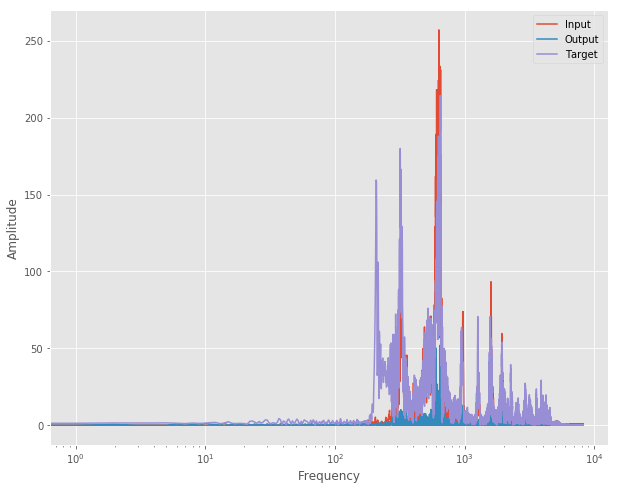

Error reading audio file: empty file or read failed in sox_read


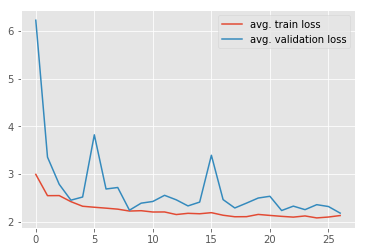

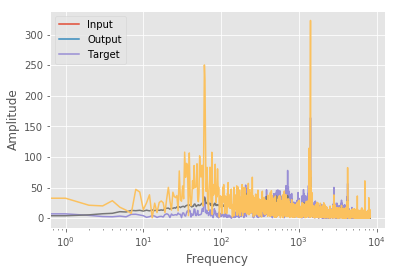

Error reading audio file: empty file or read failed in sox_read


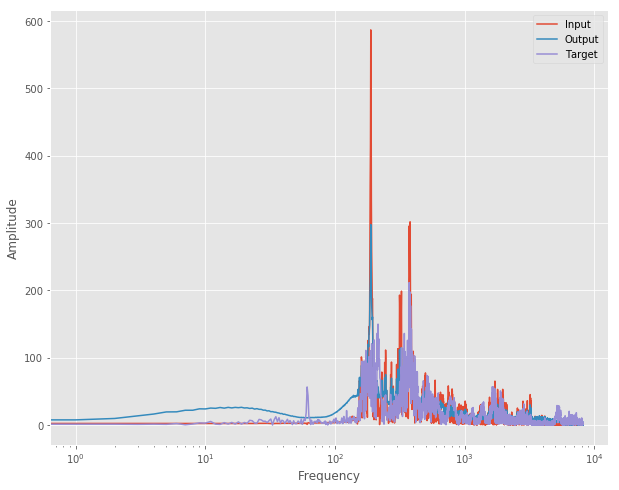

Error reading audio file: empty file or read failed in sox_read


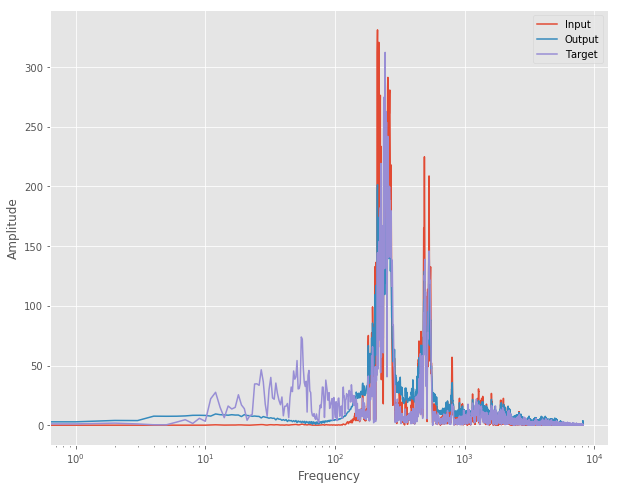

Error reading audio file: empty file or read failed in sox_read


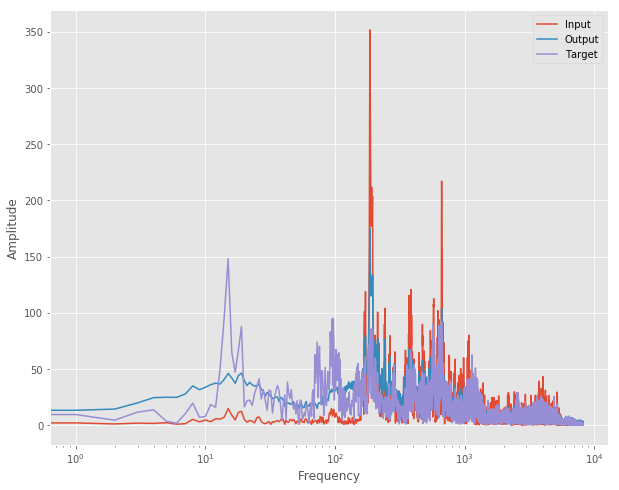

Error reading audio file: empty file or read failed in sox_read


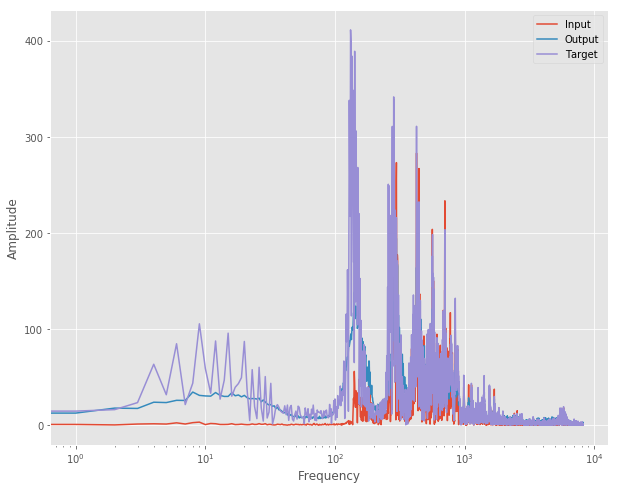

Error reading audio file: empty file or read failed in sox_read


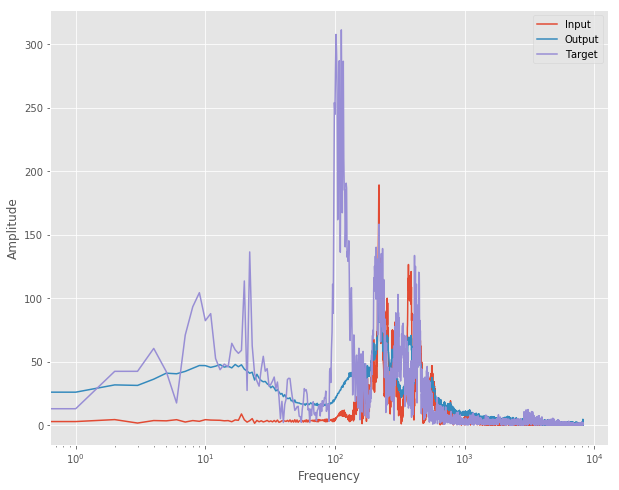

Error reading audio file: empty file or read failed in sox_read


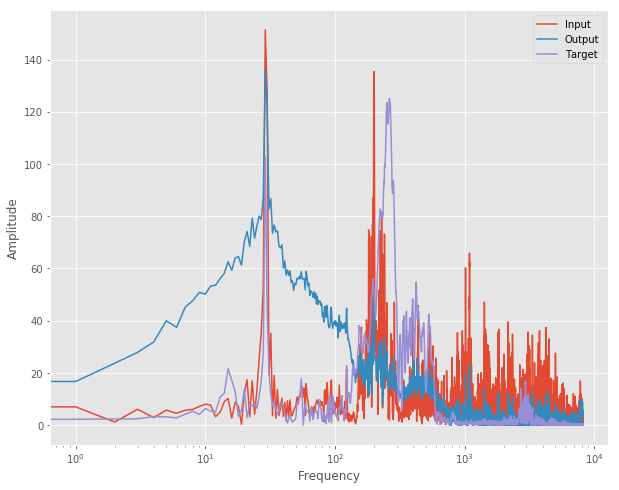

Error reading audio file: empty file or read failed in sox_read


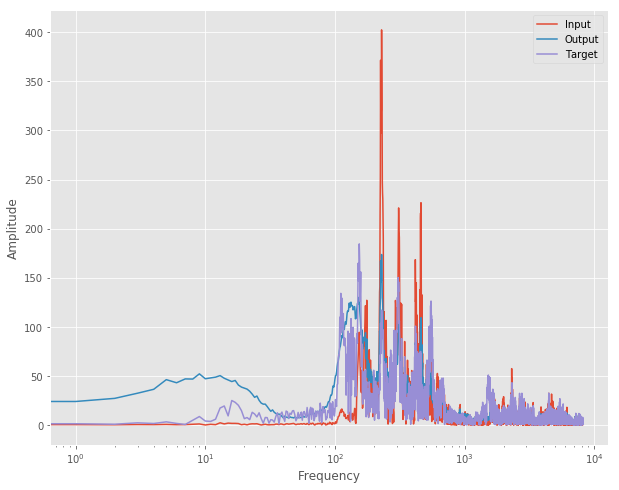

Error reading audio file: empty file or read failed in sox_read


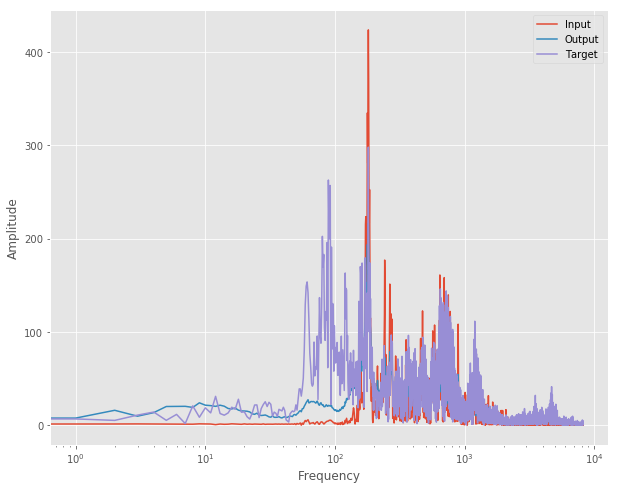

Error reading audio file: empty file or read failed in sox_read
Error reading audio file: empty file or read failed in sox_read


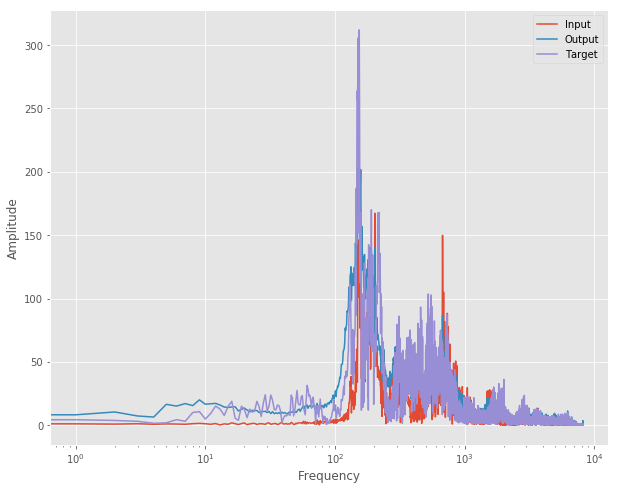

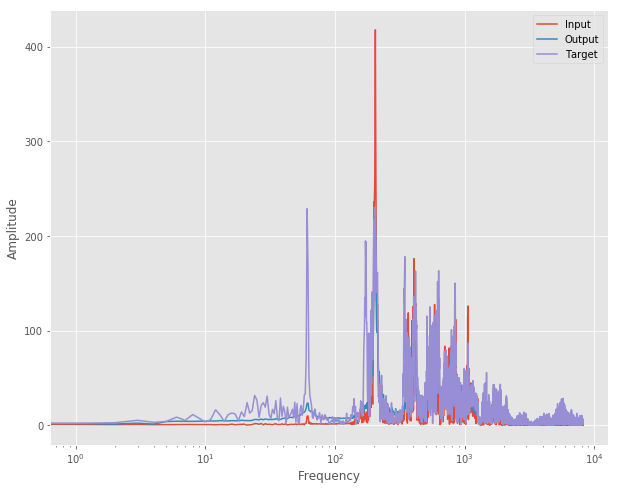

Error reading audio file: empty file or read failed in sox_read
Error reading audio file: empty file or read failed in sox_read


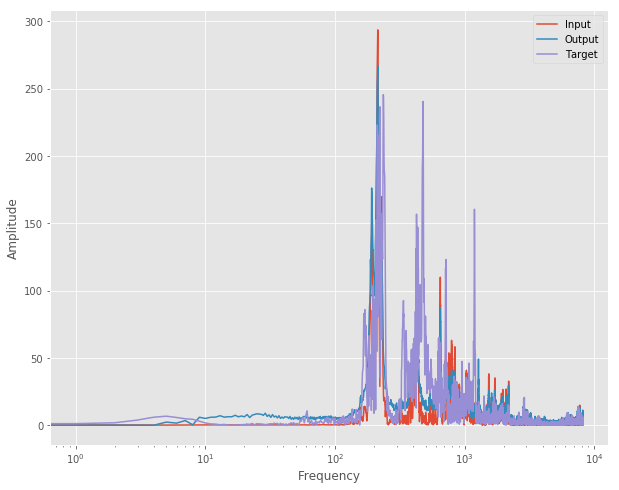

Error reading audio file: empty file or read failed in sox_read


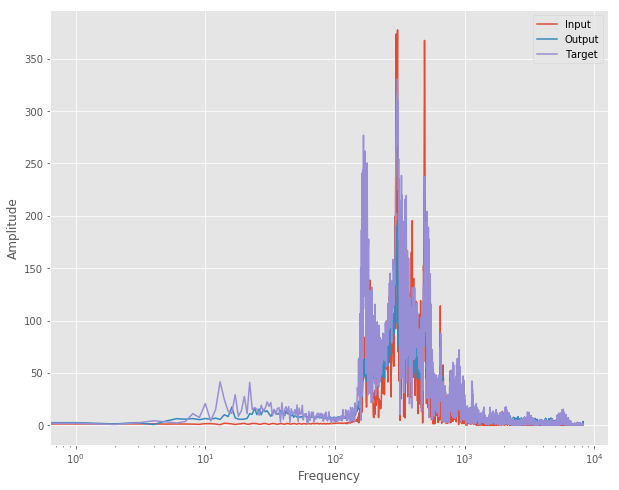

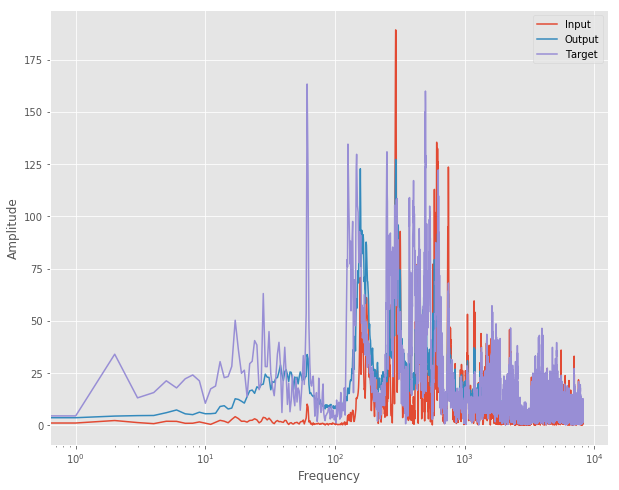

Error reading audio file: empty file or read failed in sox_read
Error reading audio file: empty file or read failed in sox_read


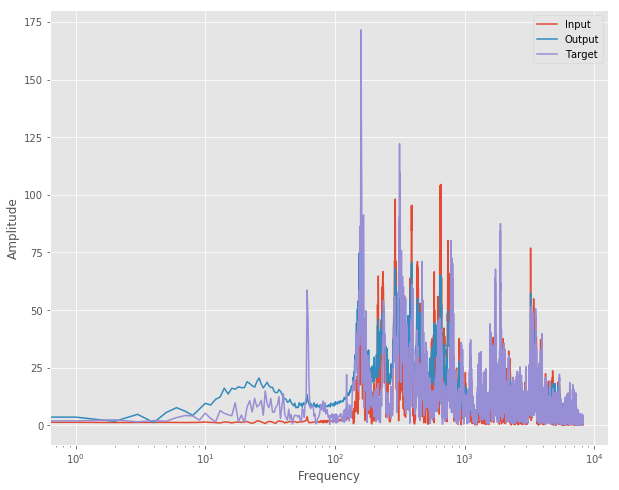

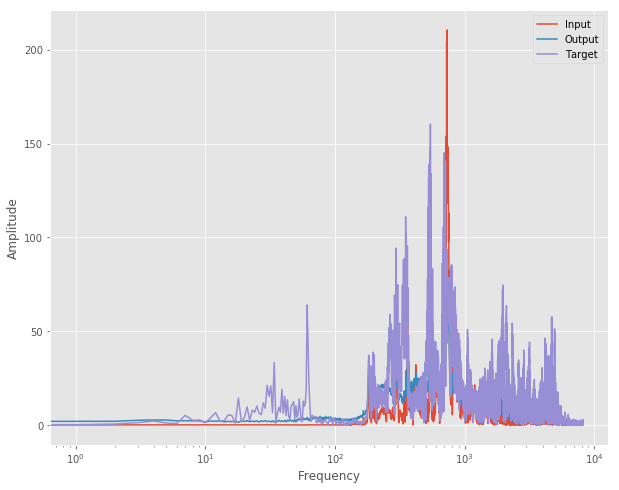

Error reading audio file: empty file or read failed in sox_read
Error reading audio file: empty file or read failed in sox_read


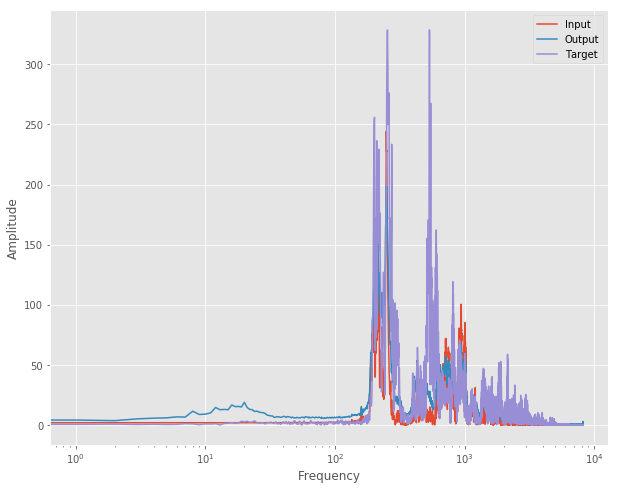

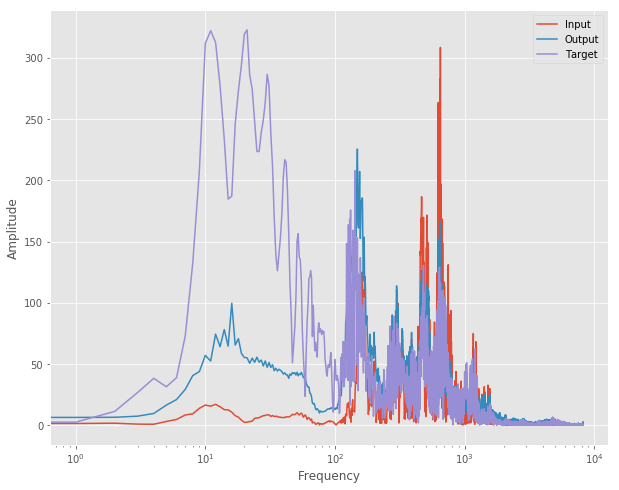

Error reading audio file: empty file or read failed in sox_read


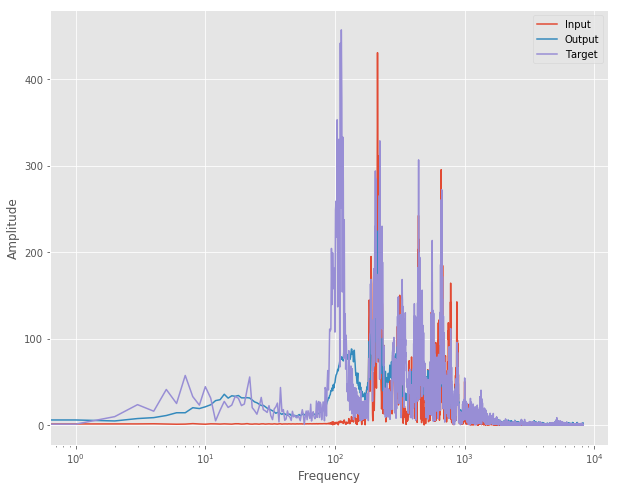

Error reading audio file: empty file or read failed in sox_read


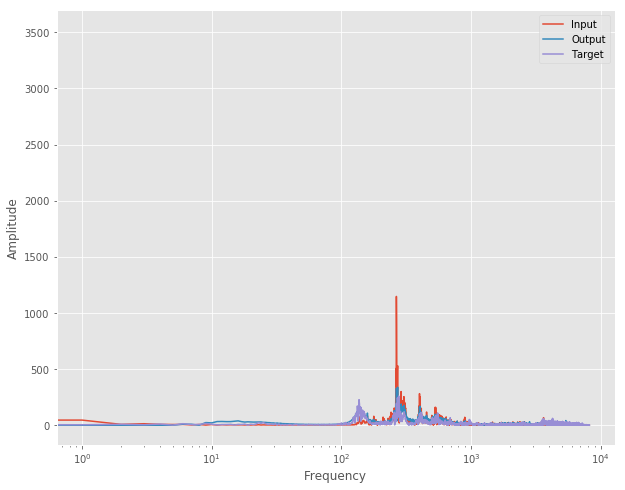

Error reading audio file: empty file or read failed in sox_read
Error reading audio file: empty file or read failed in sox_read


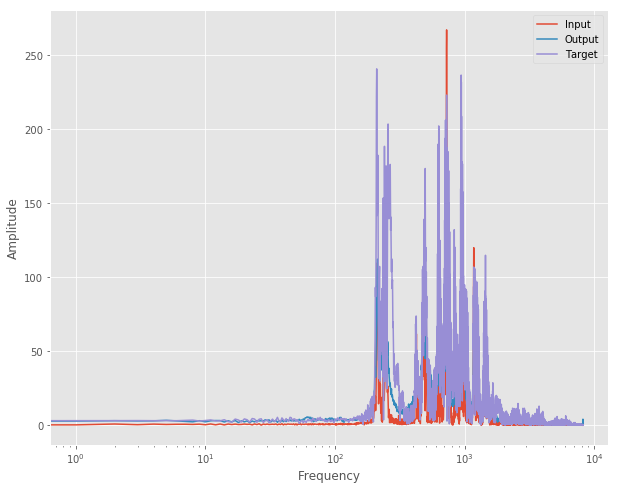

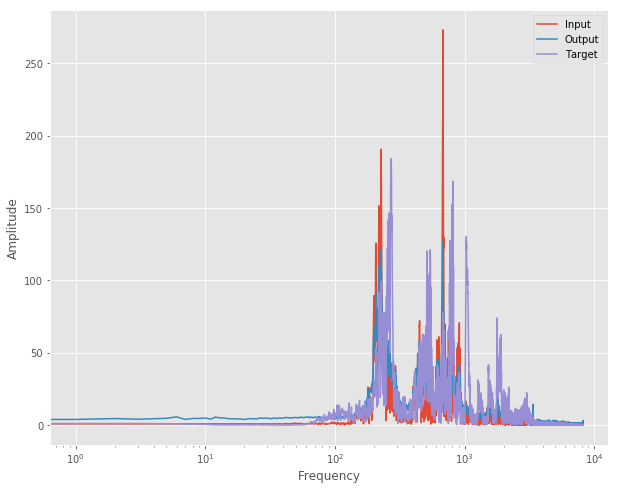

Error reading audio file: empty file or read failed in sox_read
Error reading audio file: empty file or read failed in sox_read


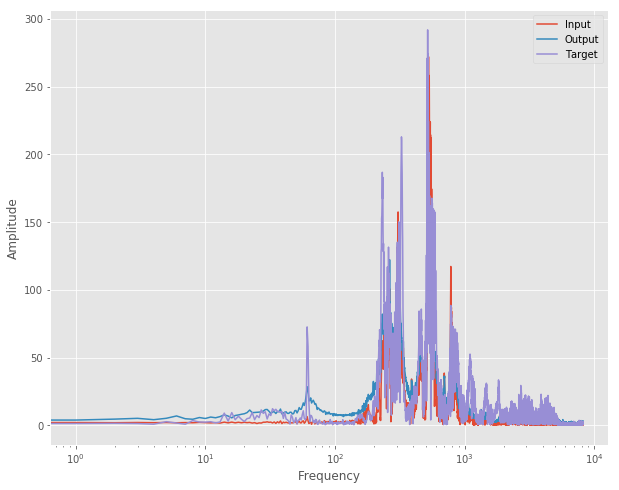

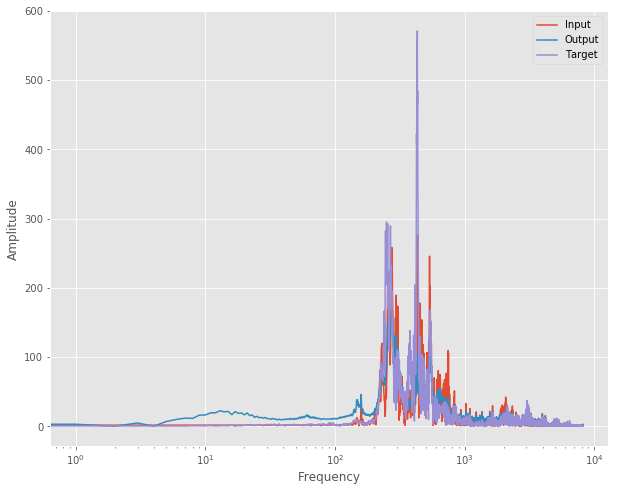

Error reading audio file: empty file or read failed in sox_read


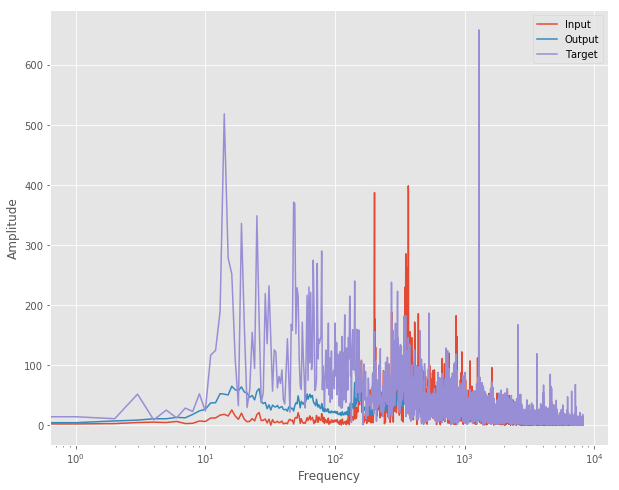

Error reading audio file: empty file or read failed in sox_read


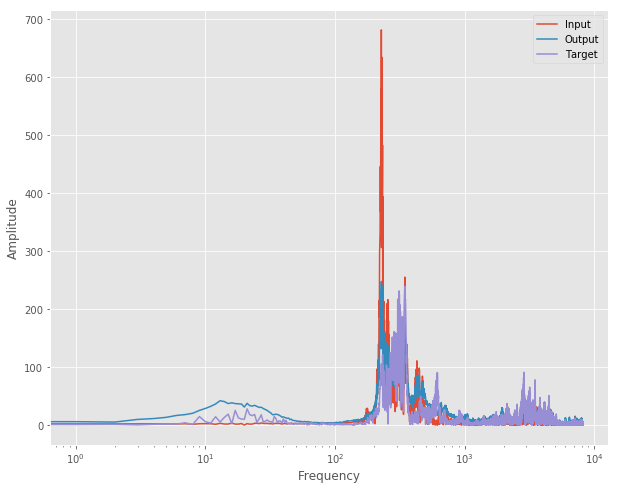

Error reading audio file: empty file or read failed in sox_read


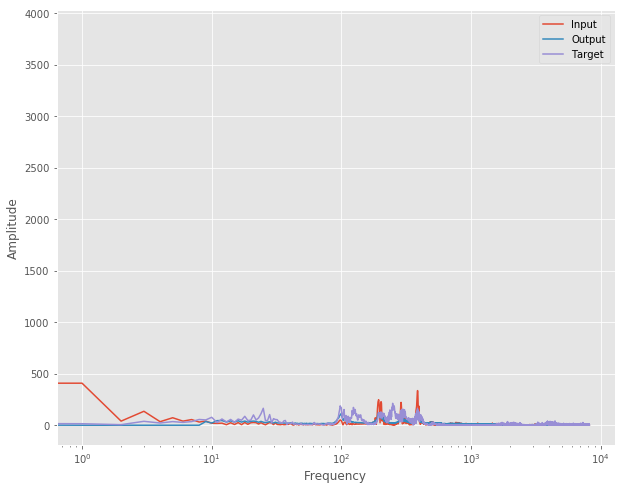

In [ ]:
loss_weight = 'percep'

if loss_weight == 'percep':
    loudness = iso226.iso226_spl_itpl(L_N=40, hfe=True, k=3)
    f = np.linspace(0, sr//2, frame_len//2)
    loud_weights = torch.from_numpy(np.float32(1/loudness(f))).cuda()
    loud_weights /= torch.mean(loud_weights)
else:
    loud_weights = torch.ones(frame_len//2).cuda()

n_epochs = 30

mb = master_bar(range(n_epochs))
mb.names = ['avg. train loss', 'avg. validation loss']
train_losses = []
valid_losses = []
for epoch in mb:
    fnet.train()
    tl = 0
    for batch_n,data in enumerate(progress_bar(train_dl, parent=mb)):

        # Index needed for some ridiculous reason because torch.rfft
        # has one extra element than it needs
        inputs =  fourier(data[0].cuda())[0][:,:,:frame_len//2]
        targets = fourier(data[1].cuda())[0][:,:,:frame_len//2]
        
        optim.zero_grad()

        outputs = fnet.forward(inputs)
        loss = critereon(outputs*loud_weights, targets*loud_weights)
        tl += loss.detach().cpu().numpy()
        
        if batch_n == 0:
            visdiff(inputs, outputs, targets)
        
        loss.backward()
        optim.step()

    train_losses.append(tl/train_size)
    
    fnet.eval()
    vl = 0
    with torch.no_grad():
        for data in progress_bar(valid_dl, parent=mb):
            inputs =  fourier(data[0].cuda())[0][:,:,:frame_len//2]
            targets = fourier(data[1].cuda())[0][:,:,:frame_len//2]

            outputs = fnet.forward(inputs)
            loss = critereon(outputs*loud_weights, targets*loud_weights)

            vl += loss.detach().cpu().numpy()

        valid_losses.append(vl/valid_size)
        
    mb.update_graph([[range(len(train_losses)), train_losses], [range(len(valid_losses)), valid_losses]])
torch.save(fnet.state_dict(), f'./models/{critereon}_{n_epochs}_{loss_weight}.pth')

In [71]:
ir_ex = ta.transforms.Resample(48000, 16000)(ta.load((data_path/'impulse-responses').ls()[2])[0])[0,:]

reverb = AudioTransforms.Reverb((data_path/'impulse-responses'), speech_sr)
noise = AudioTransforms.Noise(data_path/'noise', None, -12, 2)

In [72]:
speech_ex, sr = ta.load(random.choice((data_path/'clean-speech').ls()))
#speech_ex = torch.randn((1, 100000))

In [73]:
reverbed = reverb(speech_ex)

In [74]:
recon_ex = fnet.reconstruct(reverbed)

In [75]:
Audio(reverbed, rate=sr)

In [76]:
Audio(recon_ex, rate=sr)

In [77]:
Audio(speech_ex, rate=speech_sr)

In [22]:
plt.style.use('seaborn-poster')

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


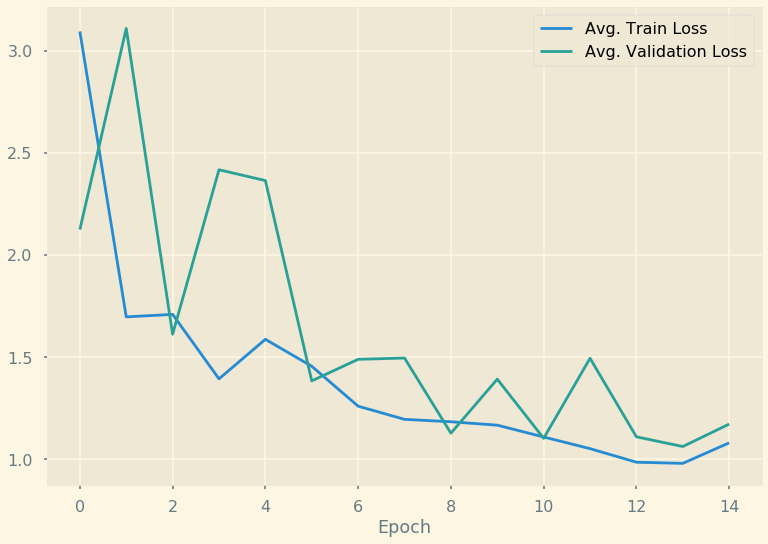

In [23]:
f = plt.figure()
plt.plot(np.asarray([train_losses, valid_losses]).T)
plt.legend(('Avg. Train Loss', 'Avg. Validation Loss'))
plt.xlabel('Epoch')
f.savefig('figs/train_15ep_mse_percep.eps', dpi=1200)

## Metrics

In [39]:
def calc_stoi(x, xhat, sr):
    mstoi = stoi(x.T, xhat.T, sr, extended=False)
    return mstoi

In [40]:
def calc_pesq(x, xhat, sr):
    mpesq = pesq(sr, x.squeeze(), xhat.squeeze(), 'wb')
    return mpesq

In [34]:
model = tnet
k = 10
speech_fs = random.sample((data_path/'clean-speech').ls(), k)
speeches = [ta.load(x)[0] for x in tqdm(speech_fs, desc="loading")]
reverbs = [rev_tfms(x) for x in tqdm(speeches, desc='applying tranforms')]
recons = [model.reconstruct(x) for x in tqdm(reverbs, desc="reconstructing")]

/home/zach/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  after removing the cwd from sys.path.


/home/zach/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  """


/home/zach/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


In [47]:
pre_stois  = [calc_stoi(speeches[i].numpy(), reverbs[i], sr) for i in tqdm(range(len(speeches)), desc="calculating pre-STOIs")]
post_stois = [calc_stoi(speeches[i].numpy(), recons[i], sr) for i in tqdm(range(len(speeches)), desc="calculating post-STOIs")]

/home/zach/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  """Entry point for launching an IPython kernel.


/home/zach/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


In [45]:
pre_pesqs  = [calc_pesq(speeches[i].numpy(), reverbs[i].numpy(), sr) for i in tqdm(range(len(speeches)), desc="calculating pre-PESQs")]
post_pesqs = [calc_pesq(speeches[i].numpy(), recons[i], sr) for i in tqdm(range(len(speeches)), desc="calculating post-PESQs")]

delta_pesqs = [post_pesqs[i] - pre_pesqs[i] for i in range(len(speech_fs))]
delta_stois = [post_stois[i] - pre_stois[i] for i in range(len(speech_fs))]

/home/zach/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  """Entry point for launching an IPython kernel.


/home/zach/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


In [50]:
df = pd.DataFrame({'file': list(map(lambda x: x.parts[-1], speech_fs)), 
                   'pre_stoi': pre_stois, 
                   'post_stoi': post_stois, 
                   'delta_stoi': delta_stois,
                   'pre_pesq': pre_pesqs, 
                   'post_pesq': post_pesqs, 
                   'delta_pesq': delta_pesqs
                  })

In [51]:
df.head()

file  pre_stoi  post_stoi  delta_stoi  pre_pesq  post_pesq  \
0  100-122655-0037.wav  0.029243   0.028735   -0.000508  1.203488   1.121983   
1  159-135897-0043.wav  0.009084   0.018058    0.008974  1.113724   1.097229   
2  159-121902-0014.wav  0.036481   0.045521    0.009040  1.365204   1.245417   
3   90-130566-0004.wav  0.024101   0.024076   -0.000024  1.194432   1.092597   
4   54-121079-0024.wav  0.040986   0.035666   -0.005320  1.174596   1.142407   

   delta_pesq  
0   -0.081504  
1   -0.016495  
2   -0.119788  
3   -0.101835  
4   -0.032189

In [64]:
df.to_csv(f'results/fnet_30_none.csv')

In [67]:
tddf = pd.read_csv('results/tnet_15.csv')
fddf = pd.read_csv('results/fnet_30_none.csv')

In [68]:
agg_df = pd.DataFrame({
    'Method': ['Frequency-domain', 'Time-domain'],
    'mean_delta_STOI': [np.mean(fddf.delta_stoi), np.mean(tddf.delta_stoi)],
    'mean_delta_PESQ': [np.mean(fddf.delta_pesq), np.mean(tddf.delta_pesq)]
})

In [69]:
agg_df.head()

Method  mean_delta_STOI  mean_delta_PESQ
0  Frequency-domain         0.000793        -0.108072
1       Time-domain         0.070448        -0.383001

In [70]:
print(agg_df.to_latex())

\begin{tabular}{llrr}
\toprule
{} &            Method &  mean\_delta\_STOI &  mean\_delta\_PESQ \\
\midrule
0 &  Frequency-domain &         0.000793 &        -0.108072 \\
1 &       Time-domain &         0.070448 &        -0.383001 \\
\bottomrule
\end{tabular}



## Compare Example Spectrograms

In [44]:
fd_uni = FDRecurNet(7).cuda()
fd_uni.load_state_dict(torch.load('./models/MSELoss()_30_None.pth'))
#fd_percep = FDConvNet(7).cuda()
#fd_percep.load_state_dict(torch.load('./models/MSELoss()_15_percep.pth'))
td = TDRecurNet(7).cuda()
td.load_state_dict(torch.load('./models/L1Loss()_30_td.pth'))

<All keys matched successfully>

In [45]:
k = 10

In [46]:
speech_fs = random.sample((data_path/'clean-speech').ls(), k)
speeches = [ta.load(x)[0] for x in tqdm(speech_fs, desc="loading")]
reverbs = [rev_tfms(x) for x in tqdm(speeches, desc='applying tranforms')]

/home/zach/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


/home/zach/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  This is separate from the ipykernel package so we can avoid doing imports until


In [47]:
n = 7
ex_clean = speeches[n]
ex_verb = reverbs[n]
recon_exs = [x.reconstruct(ex_verb).squeeze() for x in tqdm([fd_uni, td])]

/home/zach/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  after removing the cwd from sys.path.


In [48]:
names = ["Frequency-domain (uniform loss weight)", "Frequency-domain (perceptual loss weight)", "Time-domain"]

In [49]:
def plot_spec(sig,sr=16000, channel=None):
    """
    Plots spectrogram of time domain signal (numpy or tensor) with default parameters.
    channel: selects one channel if input has multiple channels
    """
    if type(sig) is torch.Tensor:
        sig = sig.squeeze().numpy()
    if channel != None:
        sig = sig[:,channel].squeeze()
    spec = db(abs(lr.stft(sig, 1024))) 
    return specshow(spec, cmap='inferno', x_axis='time', y_axis='mel', sr=sr)

In [50]:
matplotlib.rc('axes', titlesize=22)

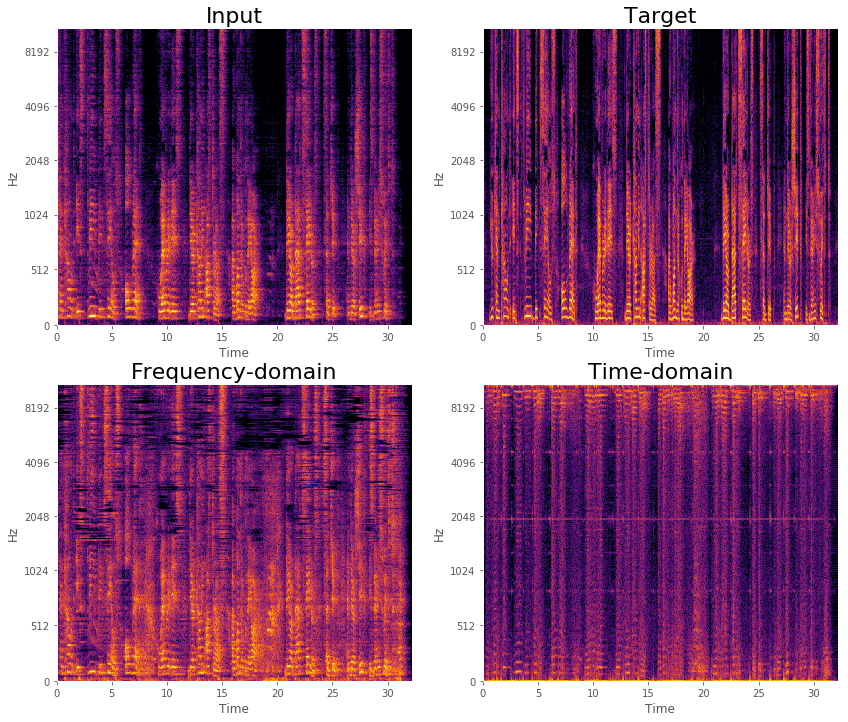

In [51]:
specs = plt.figure(figsize=(14,12))
plt.subplot(2, 2, 2)
plt.title("Target")
plot_spec(ex_clean)
plt.subplot(2, 2, 1)
plt.title("Input")
plot_spec(ex_verb)
plt.subplot(2, 2, 3)
plt.title("Frequency-domain")
plot_spec(recon_exs[0], sr)
plt.subplot(2, 2, 4)
plt.title(names[2])
plot_spec(recon_exs[1], sr)
specs.savefig('figs/specs.png', dpi=1200)

## Time Domain Conv

In [11]:
class TDConvNet(nn.Module):
    def __init__(self, kernel_size):
        super(TDConvNet, self).__init__()
        sizes = [(2048, 64), (1024, 64), (512, 64), (256, 128), (128, 128), (64, 128), (32, 256), (16,256), (8, 256)]
        self.sizes = sizes
        padding = kernel_size // 2
        self.input = nn.Conv1d(1, sizes[0][1], kernel_size, 1, padding)
        
        self.encoder = nn.Sequential(
            *[encoder_block(sizes, i, kernel_size, padding) for i in range(1, len(sizes))]
        )
        self.decoder = nn.Sequential(
            *[decoder_block(sizes, i, kernel_size, padding) for i in range(2,len(sizes)+1)]
        )
        
        self.output = nn.ConvTranspose1d(sizes[0][1], 1, kernel_size, 1, padding)
        
    def forward(self, x):
        x = self.input(x)
        enc_outs = []
        for l in self.encoder:
            x = F.relu(l(x))
            enc_outs.append(x)
        for i,l in enumerate(self.decoder):
            x = F.relu(l(torch.cat((x, enc_outs[-i-1]), 1)))
        x = torch.tanh(self.output(x))
        return x
    
    def reconstruct(self, x, hop_len=256):
        x = x.detach().cpu()
        size = 2*self.sizes[0][0]
        window = torch.from_numpy(cola_window(size, hop_len)).float()
        output = torch.zeros(x.shape)
        for frame in range(x.shape[-1]//hop_len):
            try:
                f = x[:,hop_len*frame:hop_len*frame+size]
                f = self.forward(f.unsqueeze(0).cuda()).detach().cpu()
                windowed = window * f.squeeze()
                output[:,hop_len*frame:hop_len*frame+windowed.shape[0]] += windowed
            except Exception as E:
                pass
        return output.numpy()

In [24]:
class TDRecurNet(nn.Module):
    def __init__(self, kernel_size):
        super(TDRecurNet, self).__init__()
        sizes = [(2048, 64), (1024, 64), (512, 64), (256, 128), (128, 128), (64, 128), (32, 256), (16,256), (8, 256)]
        self.sizes = sizes
        padding = kernel_size // 2
        self.input = nn.Conv1d(1, sizes[0][1], kernel_size, 1, padding)
        
        self.encoder = nn.Sequential(
            *[encoder_block(sizes, i, kernel_size, padding) for i in range(1, len(sizes))]
        )
        self.decoder = nn.Sequential(
            *[decoder_block(sizes, i, kernel_size, padding) for i in range(2,len(sizes)+1)]
        )
        
        self.output = nn.ConvTranspose1d(sizes[0][1], 1, kernel_size, 1, padding)
        self.rnn = nn.LSTM(256, 256)
        
    def forward(self, x):
        x = self.input(x)
        enc_outs = []
        for l in self.encoder:
            x = F.relu(l(x))
            enc_outs.append(x)
        x = x.permute(2, 0, 1)
        x,_ = self.rnn(x)
        x = x.permute(1, 2, 0)
        for i,l in enumerate(self.decoder):
            x = F.relu(l(torch.cat((x, enc_outs[-i-1]), 1)))
        x = torch.tanh(self.output(x))
        return x
    
    def reconstruct(self, x, hop_len=256):
        x = x.detach().cpu()
        size = 8192#2*self.sizes[0][0]
        window = torch.from_numpy(cola_window(size, hop_len)).float()
        output = torch.zeros(x.shape)
        for frame in range(x.shape[-1]//hop_len):
            try:
                f = x[:,hop_len*frame:hop_len*frame+size]
                f = self.forward(f.unsqueeze(0).cuda()).detach().cpu()
                windowed = window * f.squeeze()
                output[:,hop_len*frame:hop_len*frame+windowed.shape[0]] += windowed
            except Exception as E:
                pass
        return output.numpy()

In [38]:
# Try to destroy any existing network on the GPU before creating new
try:
    del tnet
except:
    pass
tnet = TDRecurNet(kernel_size=7)
tnet.cuda()
#critereon = nn.MSELoss()
critereon = nn.L1Loss()
optim = torch.optim.Adam(tnet.parameters(), lr=1e-3)

In [26]:
tnet.load_state_dict(torch.load('./models/MSELoss()_30_td.pth'))

<All keys matched successfully>

Error reading audio file: empty file or read failed in sox_read


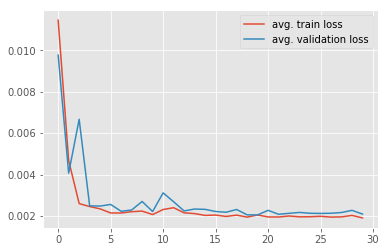

Error reading audio file: empty file or read failed in sox_read
Error reading audio file: empty file or read failed in sox_read
Error reading audio file: empty file or read failed in sox_read
Error reading audio file: empty file or read failed in sox_read
Error reading audio file: empty file or read failed in sox_read
Error reading audio file: empty file or read failed in sox_read
Error reading audio file: empty file or read failed in sox_read
Error reading audio file: empty file or read failed in sox_read
Error reading audio file: empty file or read failed in sox_read
Error reading audio file: empty file or read failed in sox_read
Error reading audio file: empty file or read failed in sox_read
Error reading audio file: empty file or read failed in sox_read
Error reading audio file: empty file or read failed in sox_read
Error reading audio file: empty file or read failed in sox_read
Error reading audio file: empty file or read failed in sox_read
Error reading audio file: empty file or 

In [39]:
n_epochs = 30

mb = master_bar(range(n_epochs))
mb.names = ['avg. train loss', 'avg. validation loss']
train_losses = []
valid_losses = []
for epoch in mb:
    tnet.train()
    tl = 0
    for batch_n,data in enumerate(progress_bar(train_dl, parent=mb)):

        # Index needed for some ridiculous reason because torch.rfft
        # has one extra element than it needs
        inputs =  data[0].cuda()
        targets = data[1].cuda()
        
        optim.zero_grad()

        outputs = tnet.forward(inputs)
        loss = critereon(outputs, targets)
        tl += loss.detach().cpu().numpy()
        
        loss.backward()
        optim.step()

    train_losses.append(tl/train_size)
    
    tnet.eval()
    vl = 0
    with torch.no_grad():
        for data in progress_bar(valid_dl, parent=mb):
            inputs =  data[0].cuda()
            targets = data[1].cuda()

            outputs = tnet.forward(inputs)
            loss = critereon(outputs, targets)

            vl += loss.detach().cpu().numpy()

        valid_losses.append(vl/valid_size)
        
    mb.update_graph([[range(len(train_losses)), train_losses], [range(len(valid_losses)), valid_losses]])
torch.save(tnet.state_dict(), f'./models/{critereon}_{n_epochs}_td.pth')

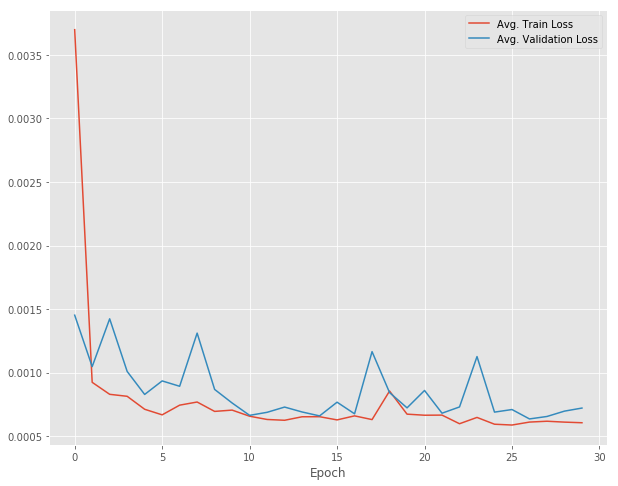

In [15]:
f = plt.figure()
plt.plot(np.asarray([train_losses, valid_losses]).T)
plt.legend(('Avg. Train Loss', 'Avg. Validation Loss'))
plt.xlabel('Epoch')
f.savefig('figs/train_30ep_td.eps', dpi=1200)

## FCNN

In [42]:
# define network
class Net(nn.Module):

    def __init__(self, num_features, num_hidden, num_output):
        super(Net, self).__init__()  
        self.l1 = nn.Linear(num_features, num_hidden)
        self.act = nn.ReLU()
        self.l2 = nn.Linear(num_hidden, num_output)

    def forward(self, x):
        x = self.l1(x)
        x = self.act(x)
        x = self.l2(x)
        return x

In [43]:
try:
    del net
except:
    pass

speech_sr = 16000
net = Net(2048, 512, 2048)
net.cuda()

Net(
  (l1): Linear(in_features=2048, out_features=512, bias=True)
  (act): ReLU()
  (l2): Linear(in_features=512, out_features=2048, bias=True)
)

In [14]:
critereon = nn.MSELoss()
optim = torch.optim.Adam(net.parameters(), lr=1e-4)

NameError: name 'net' is not defined

In [ ]:
n_epochs = 100

mb = master_bar(range(n_epochs))
mb.names = ['train loss']
epoch_losses = []
for epoch in mb:
    for data in progress_bar(dl, parent=mb):

        epoch_loss = 0

        inputs = data['reverbed'].cuda()
        targets = data['clean'].cuda()

        outputs = net.forward(inputs)
        loss = critereon(outputs, targets)
        loss.backward()
        optim.step()
        optim.zero_grad()

        epoch_loss += loss.cpu().detach().numpy()
        
    epoch_losses.append(epoch_loss)
    mb.update_graph([[range(epoch+1), epoch_losses]])
    #print(f'epoch {epoch} loss: {epoch_loss}')

In [144]:
net.eval()
output = net.forward(next(iter(dl))['reverbed'].cuda())
output = output[0,:].squeeze().detach().cpu()

In [148]:
Audio(output, rate=16000)

## Perceptual Weighting

In [ ]:
loudness = iso226.iso226_spl_itpl(L_N=40, hfe=True, k=3)
f = np.linspace(0, 20000, 2048)
f_tens = torch.from_numpy(np.float32(1/loudness(f))).cuda()
f_tens /= torch.max(f_tens)

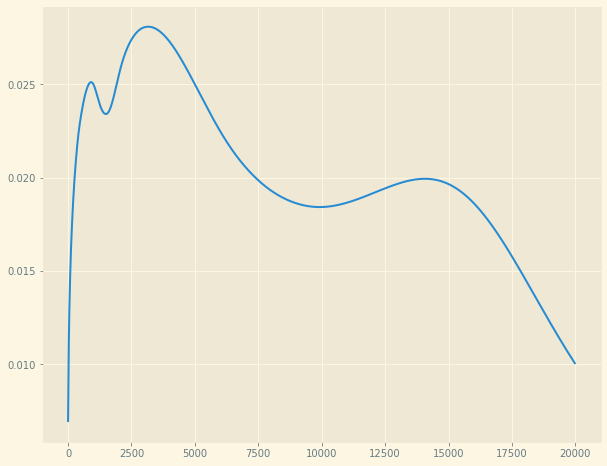

In [125]:
loudness = iso226.iso226_spl_itpl(L_N=40, hfe=True, k=3)

f = np.linspace(0, 20000, 2048)

plt.plot(f, 1/loudness(f))

In [147]:
f_tens = torch.from_numpy(np.float32(1/loudness(f))).cuda()

In [148]:
f_tens /= torch.max(f_tens)

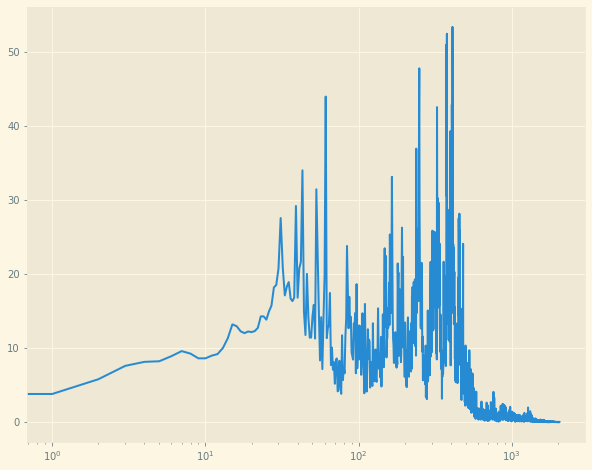

In [149]:
plt.plot((outputs.squeeze()[0,:]*f_tens).squeeze().cpu().detach().numpy())
plt.xscale('log')

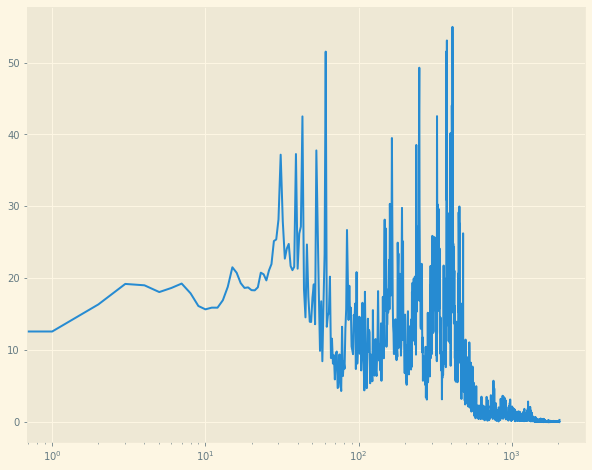

In [150]:
plt.plot(outputs[0,:,:].squeeze().cpu().detach().numpy())
plt.xscale('log')